# Explore overlap between Neanderthal-introgressed SNPs and Fairfax eQTLs
This code explores if any Neanderthal-introgressed SNPs are present in the list of monocyte extreme response peak eQTLs identified by Fairfax et al. Fisher's exact test and bootstrap test were performed to detect enrichment.

Neanderthal SNPs from:
1. Dannemann M, Prufer K & Kelso J. Functional implications of Neandertal introgression in modern humans. Genome Biol 2017 18:61.
2. Simonti CN *et al*. The phenotypic legacy of admixture between modern humans and Neandertals. Science 2016 351:737-41.

Monocyte extreme response peak eQTLs from:
1. Fairfax BP *et al*. Innate immune activity conditions the effect of regulatory variants upon monocyte gene expression. Science 2014 343:1246949.

In [1]:
# Import libraries
import pandas as pd
import scipy.stats as stats
from random import sample
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

### Create dataframe containing SNPs in both Neanderthal and Fairfax datasets

In [2]:
# Load comparison_df containing Neanderthal SNPs
comparison_df = pd.read_csv("../neanderthal/comparison_df.csv")
comparison_df = comparison_df.drop(columns='Unnamed: 0')
comparison_df['Source'] = comparison_df['Source'].astype('string')

In [3]:
# Load eQTL data
extr_resp = pd.read_csv("tab2_a_cis_eSNPs.txt", sep="\t", usecols=["SNP", "Gene", "SNP.Chrm", "SNP.pos", "Min.dataset"])
extr_resp = extr_resp.rename(columns={"SNP.Chrm": "Chromosome", "SNP.pos": "Position", "SNP": "ID"})
extr_resp = extr_resp.groupby(["Chromosome", "Position", "ID"]).agg(','.join).reset_index()

In [4]:
# Merge dataframes
extr_resp_df = comparison_df.merge(extr_resp, how='left', on=['Chromosome', 'Position'])
extr_resp_df = extr_resp_df.dropna()
extr_resp_df.head()

,Chromosome,Position,Source,ID,Gene,Min.dataset
1416,1,21636746,both,rs12756690,ECE1,LPS2
2197,1,40145850,both,rs17560858,LOC728448,IFN
2357,1,41488722,both,rs11209368,CTPS,IFN
2397,1,41702942,both,rs10493094,CTPS,IFN
10651,1,223003498,both,rs17475774,DISP1,LPS24


In [5]:
# Number of overlapping SNPs
len(extr_resp_df)

111

In [6]:
# Expression context
extr_resp_df['Min.dataset'].str.split(',', expand=True).stack().value_counts()

IFN      43
LPS24    35
LPS2     29
Naive    28
dtype: int64

In [7]:
# Genes associated with overlapped eQTLs
extr_resp_df['Gene'].str.split(',', expand=True).stack().value_counts()

NFATC1    3
OAS1      3
LRP3      2
DDRGK1    2
KTELC1    2
         ..
XPO5      1
RHOG      1
MMP10     1
ZNF143    1
TCEA2     1
Length: 117, dtype: int64

In [8]:
# African population MAFs
allpop_df = pd.read_csv("../neanderthal/allpop_fixed.csv")
extr_resp_df = extr_resp_df.merge(allpop_df, how='left', on=['Chromosome', 'Position', 'ID', 'Source'])
extr_resp_df[['ESN', 'YRI', 'MSL', 'GWD', 'LWK']].describe()

,ESN,YRI,MSL,GWD,LWK
count,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.002373,0.000964,0.002491,0.004791,0.004791
std,0.008185,0.004714,0.008577,0.012084,0.009825
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.004000,0.005000
max,0.061000,0.032000,0.065000,0.102000,0.056000


---

## Check for enrichment of Neanderthal SNPs in Fairfax eQTLs

### Fisher's exact test

In [9]:
# Number of Neanderthal SNPs in all genotyped Fairfax SNPs
all_genotyped_snps = pd.read_csv("extreme_response/extreme_response.bim", sep="\t", header=None)
all_genotyped_snps.drop(2, axis=1, inplace=True)
all_genotyped_snps = all_genotyped_snps.rename(columns={0: "Chromosome", 1: "ID", 3: "Position",
                                                        4: "Major", 5: "Minor"})
merged = comparison_df.merge(all_genotyped_snps, how="left", on=["Chromosome", "Position"])
merged = merged.dropna()
len(merged)

3288

In [10]:
stats.fisher_exact([[111, 18900], [3177, 610799]])

(1.1291256601266044, 0.2185106335371457)

### Bootstrap test

In [11]:
# All genotyped SNPs from Fairfax
exre = open('bootstrap/extreme_response.txt', 'r').read().splitlines()
# Dannemann Neanderthal SNPs
dann = open('bootstrap/dann_extres.txt', 'r').read().splitlines()
# Simonti Neanderthal SNPs
simo = open('bootstrap/simo_extres.txt', 'r').read().splitlines()

In [12]:
# Fairfax eQTLs 
eSNP = []
for chrom,pos in zip(extr_resp['Chromosome'], extr_resp['Position']):
    eSNP.append(str(chrom) + ' ' + str(pos))

In [13]:
# Overlap between Dannemann Neanderthal SNPs and Fairfax eQTLs
dann_exre = set(dann).intersection(eSNP)
len(dann_exre)

97

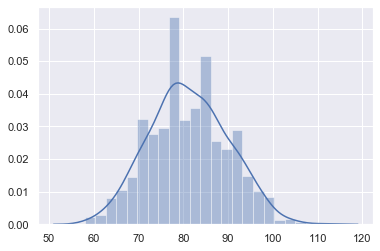

In [14]:
# Dannemann bootstap 
dann_results = []
for i in range(1000):
    dann_results.append(len(set(sample(exre, len(dann))).intersection(eSNP)))
sns.distplot(dann_results)

In [15]:
# Overlap between Simonti Neanderthal SNPs and Fairfax eQTLs
simo_exre = set(simo).intersection(eSNP)
len(simo_exre)

41

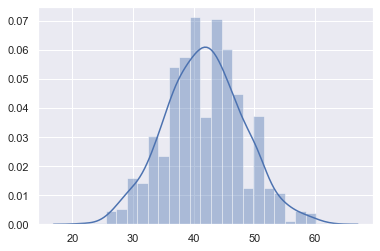

In [16]:
# Simonti bootstrap
simo_results = []
for i in range(1000):
    simo_results.append(len(set(sample(exre, len(simo))).intersection(eSNP)))
sns.distplot(simo_results)

In [17]:
# Overlap between combined Neanderthal SNPs and Fairfax eQTLs
combined = set(dann).union(simo)
combined_exre = set(combined).intersection(eSNP)
len(combined_exre)

110

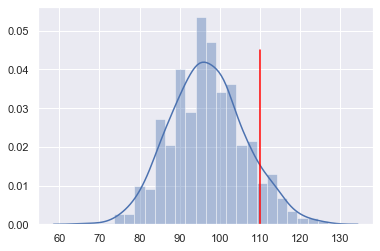

In [18]:
# Combined bootstrap
combined_results = []
for i in range(1000):
    combined_results.append(len(set(sample(exre, len(combined))).intersection(eSNP)))
sns.distplot(combined_results)
plt.plot([110, 110], [0, 0.045], color='red', label='110')
plt.show()

---

## Check for enrichment of Neanderthal SNPs in IFN-specific vs LPS-specific eQTLs

### Fisher's exact test

In [19]:
# Number of Fairfax eQTLs that are IFN-specific or LPS-specific
IFN_count = 0
LPS_count = 0
eqtl_ifn = []
eqtl = []
for index, row in extr_resp.iterrows():
    if 'IFN' in row['Min.dataset'] and 'LPS' not in row['Min.dataset']:
        IFN_count += 1
        eqtl_ifn.append(row['ID'])
        eqtl.append(row['ID'])
    elif 'IFN' not in row['Min.dataset'] and 'LPS' in row['Min.dataset']:
        LPS_count += 1
        eqtl.append(row['ID'])
print('IFN: ' + str(IFN_count) + ', LPS: ' + str(LPS_count))

IFN: 5270, LPS: 8923


In [20]:
# Number of Neanderthal-introgressed, Fairfax eQTLs that are IFN-specific or LPS-specific
IFN_count = 0
LPS_count = 0
nean_eqtl = []
for index, row in extr_resp_df.iterrows():
    if 'IFN' in row['Min.dataset'] and 'LPS' not in row['Min.dataset']:
        IFN_count += 1
        nean_eqtl.append(row['ID'])
    elif 'IFN' not in row['Min.dataset'] and 'LPS' in row['Min.dataset']:
        LPS_count += 1
        nean_eqtl.append(row['ID'])
print('IFN: ' + str(IFN_count) + ', LPS: ' + str(LPS_count))

IFN: 34, LPS: 52


In [21]:
stats.fisher_exact([[34, 5236], [52, 8871]])

(1.1077672327672328, 0.6553010929498944)

### Bootstrap test

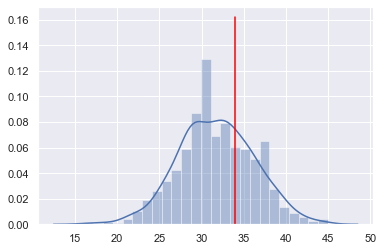

In [22]:
bootstrap = []
for i in range(1000):
    bootstrap.append(len(set(sample(eqtl, len(nean_eqtl))).intersection(eqtl_ifn)))
sns.distplot(bootstrap)
plt.plot([34, 34], [0, 0.162], color='red', label='34')
plt.show()